In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
import numpy as np
import time
import ast

In [12]:
gamma_def = 1/10
lambda_def = 2/365
R0_def = 2
beta_def = R0_def * gamma_def

f_B_def = 1
sigma_def = 1.1
mu_def = 2
nu_def = 1/365
eta_def = .05
delta_def = .05/365
rho_def = .05

pop_size_def = 1e6
r_tolerance_def = 1e-6

In [13]:
def model(y, t,
          f_A, f_B,
          beta, gamma, lambd,
          sigma, mu, epsilon,
          nu, eta,
          kA, kB, pw_init, A_weights, B_weights):
    Sw_1A, Sw_2A, Iw_wA, Rw_A, \
    Sw_1B, Sw_2B, Iw_wB, Rw_B, \
    pw, pA, pB, C_A, C_B = y[:13]
    
    SA_1As = y[13:(13 + kA)]
    SA_2As = y[(13 + kA):(13 + 2*kA)]
    IA_wAs = y[(13 + 2*kA):(13 + 3*kA)]
    IA_vAs = y[(13 + 3*kA):(13 + 4*kA)]
    RA_As = y[(13 + 4*kA):(13 + 5*kA)]
    SA_1Bs = y[(13 + 5*kA):(13 + 6*kA)]
    SA_2Bs = y[(13 + 6*kA):(13 + 7*kA)]
    IA_wBs = y[(13 + 7*kA):(13 + 8*kA)]
    IA_vBs = y[(13 + 8*kA):(13 + 9*kA)]
    RA_Bs = y[(13 + 9*kA):(13 + 10*kA)]
    
    SB_1As = y[(13 + 10*kA):(13 + 10*kA + kB)]
    SB_2As = y[(13 + 10*kA + kB):(13 + 10*kA + 2*kB)]
    IB_wAs = y[(13 + 10*kA + 2*kB):(13 + 10*kA + 3*kB)]
    IB_vAs = y[(13 + 10*kA + 3*kB):(13 + 10*kA + 4*kB)]
    RB_As = y[(13 + 10*kA + 4*kB):(13 + 10*kA + 5*kB)]
    SB_1Bs = y[(13 + 10*kA + 5*kB):(13 + 10*kA + 6*kB)]
    SB_2Bs = y[(13 + 10*kA + 6*kB):(13 + 10*kA + 7*kB)]
    IB_wBs = y[(13 + 10*kA + 7*kB):(13 + 10*kA + 8*kB)]
    IB_vBs = y[(13 + 10*kA + 8*kB):(13 + 10*kA + 9*kB)]
    RB_Bs = y[(13 + 10*kA + 9*kB):(13 + 10*kA + 10*kB)]
    
    beta_w = beta
    beta_v = sigma * beta

    
    dSw_1A = -beta_w * ((1-eta) * Iw_wA + eta * Iw_wB) * Sw_1A - (1 - f_A) * nu * Sw_1A
    dSw_2A = lambd * Rw_A
    dIw_wA = beta_w * ((1-eta) * Iw_wA + eta * Iw_wB) * Sw_1A - gamma * Iw_wA
    dRw_A = gamma * Iw_wA - lambd * Rw_A + (1 - f_A) * nu * Sw_1A
     
    dSw_1B = -beta_w * ((1-eta) * Iw_wB + eta * Iw_wA) * Sw_1B - min(f_A, f_B) * nu * Sw_1B
    dSw_2B = lambd * Rw_B
    dIw_wB = beta_w * ((1-eta) * Iw_wB + eta * Iw_wA) * Sw_1B - gamma * Iw_wB
    dRw_B = gamma * Iw_wB - lambd * Rw_B + min(f_A, f_B) * nu * Sw_1B
    

    dSA_1As = -beta_w * ((1-eta) * IA_wAs + eta * IA_wBs) * SA_1As - beta_v * ((1-eta) * IA_vAs + eta * IA_vBs) * SA_1As - (1 - f_A) * nu * SA_1As
    dSA_2As = lambd * RA_As - epsilon * beta_v * ((1-eta) * IA_vAs + eta * IA_vBs) * SA_2As
    dIA_wAs = beta_w * ((1-eta) * IA_wAs + eta * IA_wBs) * SA_1As - gamma * IA_wAs
    dIA_vAs = beta_v * ((1-eta) * IA_vAs + eta * IA_vBs) * (SA_1As + epsilon * SA_2As) - gamma * IA_vAs
    dRA_As = gamma * (IA_wAs + IA_vAs) - lambd * RA_As + (1 - f_A) * nu * SA_1As
    
    dSA_1Bs = -beta_w * ((1-eta) * IA_wBs + eta * IA_wAs) * SA_1Bs - beta_v * ((1-eta) * IA_vBs + eta * IA_vAs) * SA_1Bs - min(f_A, f_B) * nu * SA_1Bs
    dSA_2Bs = lambd * RA_Bs - epsilon * beta_v * ((1-eta) * IA_vBs + eta * IA_vAs) * SA_2Bs
    dIA_wBs = beta_w * ((1-eta) * IA_wBs + eta * IA_wAs) * SA_1Bs - gamma * IA_wBs
    dIA_vBs = beta_v * ((1-eta) * IA_vBs + eta * IA_vAs) * (SA_1Bs + epsilon * SA_2Bs) - gamma * IA_vBs
    dRA_Bs = gamma * (IA_wBs + IA_vBs) - lambd * RA_Bs + min(f_A, f_B) * nu * SA_1Bs
    
    
    dSB_1As = -beta_w * ((1-eta) * IB_wAs + eta * IB_wBs) * SB_1As - beta_v * ((1-eta) * IB_vAs + eta * IB_vBs) * SB_1As - (1 - f_A) * nu * SB_1As
    dSB_2As = lambd * RB_As - epsilon * beta_v * ((1-eta) * IB_vAs + eta * IB_vBs) * SB_2As
    dIB_wAs = beta_w * ((1-eta) * IB_wAs + eta * IB_wBs) * SB_1As - gamma * IB_wAs
    dIB_vAs = beta_v * ((1-eta) * IB_vAs + eta * IB_vBs) * (SB_1As + epsilon * SB_2As) - gamma * IB_vAs
    dRB_As = gamma * (IB_wAs + IB_vAs) - lambd * RB_As + (1 - f_A) * nu * SB_1As
    
    dSB_1Bs = -beta_w * ((1-eta) * IB_wBs + eta * IB_wAs) * SB_1Bs - beta_v * ((1-eta) * IB_vBs + eta * IB_vAs) * SB_1Bs - min(f_A, f_B) * nu * SB_1Bs
    dSB_2Bs = lambd * RB_Bs - epsilon * beta_v * ((1-eta) * IB_vBs + eta * IB_vAs) * SB_2Bs
    dIB_wBs = beta_w * ((1-eta) * IB_wBs + eta * IB_wAs) * SB_1Bs - gamma * IB_wBs
    dIB_vBs = beta_v * ((1-eta) * IB_vBs + eta * IB_vAs) * (SB_1Bs + epsilon * SB_2Bs) - gamma * IB_vBs
    dRB_Bs = gamma * (IB_wBs + IB_vBs) - lambd * RB_Bs + min(f_A, f_B) * nu * SB_1Bs

    
    rA = mu * beta_w * Sw_1A * ((1-eta) * Iw_wA + eta * Iw_wB) * np.maximum(0, 1 - gamma/(beta_v * (Sw_1A + epsilon * Sw_2A)))
    rB = mu * beta_w * Sw_1B * ((1-eta) * Iw_wB + eta * Iw_wA) * np.maximum(0, 1 - gamma/(beta_v * (Sw_1B + epsilon * Sw_2B)))
    
    dpw = -(rA + rB) * pw
    dpA = rA * pw
    dpB = rB * pw
    
    dC_A = pw_init * Iw_wA + sum(A_weights * (IA_wAs + IA_vAs)) + sum(B_weights * (IB_wAs + IB_vAs))
    dC_B = pw_init * Iw_wB + sum(A_weights * (IA_wBs + IA_vBs)) + sum(B_weights * (IB_wBs + IB_vBs))
    
    return np.concatenate(([dSw_1A, dSw_2A, dIw_wA, dRw_A,
                            dSw_1B, dSw_2B, dIw_wB, dRw_B,
                            dpw, dpA, dpB, dC_A, dC_B],
                           dSA_1As, dSA_2As, dIA_wAs, dIA_vAs, dRA_As,
                           dSA_1Bs, dSA_2Bs, dIA_wBs, dIA_vBs, dRA_Bs,
                           dSB_1As, dSB_2As, dIB_wAs, dIB_vAs, dRB_As,
                           dSB_1Bs, dSB_2Bs, dIB_wBs, dIB_vBs, dRB_Bs))

In [14]:
def get_dCs(f_A, f_B=f_B_def,
            beta=beta_def, gamma=gamma_def, lambd=lambda_def,
            sigma=sigma_def, mu=mu_def, epsilon=None,
            nu=nu_def, eta=eta_def,
            pop_size=pop_size_def, r_tolerance=r_tolerance_def,
            tstep=7, tsteps=1000, ts_per_tstep=1, track_vars=False):
    tstep_ts = np.linspace(0, tsteps * tstep, tsteps + 1)
    all_ts = np.linspace(0, tsteps * tstep, tsteps * ts_per_tstep + 1)
    init = 1 / pop_size
    if epsilon is None:
        epsilon = 1 / (sigma * beta / gamma)
    
    kA = 0
    kB = 0
    pw_init = 1
    A_weights = []
    B_weights = []
    
    y0 = [1 - init, 0, init, 0,
          1 - init, 0, init, 0,
          1, 0, 0, 0, 0]

    if track_vars:
        Sw_1A = [1 - init]
        Sw_2A = [0]
        Iw_wA = [init]
        Rw_A = [0]
        Sw_1B = [1 - init]
        Sw_2B = [0]
        Iw_wB = [init]
        Rw_B = [0]
        pw = [pw_init]
        pA = [0]
        pB = [0]

        SA_1As = [[]]
        SA_2As = [[]]
        IA_wAs = [[]]
        IA_vAs = [[]]
        RA_As = [[]]
        SA_1Bs = [[]]
        SA_2Bs = [[]]
        IA_wBs = [[]]
        IA_vBs = [[]]
        RA_Bs = [[]]
        SB_1As = [[]]
        SB_2As = [[]]
        IB_wAs = [[]]
        IB_vAs = [[]]
        RB_As = [[]]
        SB_1Bs = [[]]
        SB_2Bs = [[]]
        IB_wBs = [[]]
        IB_vBs = [[]]
        RB_Bs = [[]]
        
    dC_A = [0]
    dC_B = [0]

    for i in range(1, tsteps + 1):
        ts = np.linspace((i-1) * tstep, i * tstep, ts_per_tstep + 1)
        params = (f_A, f_B,
                  beta, gamma, lambd,
                  sigma, mu, epsilon,
                  nu, eta,
                  kA, kB, pw_init, A_weights, B_weights)
        
        odes = scipy.integrate.odeint(model, y0, ts, args = params)

        if track_vars:
            Sw_1A = np.append(Sw_1A, odes[1:,0])
            Sw_2A = np.append(Sw_2A, odes[1:,1])
            Iw_wA = np.append(Iw_wA, odes[1:,2])
            Rw_A = np.append(Rw_A, odes[1:,3])
            Sw_1B = np.append(Sw_1B, odes[1:,4])
            Sw_2B = np.append(Sw_2B, odes[1:,5])
            Iw_wB = np.append(Iw_wB, odes[1:,6])
            Rw_B = np.append(Rw_B, odes[1:,7])
            pw = np.append(pw, odes[1:,8])
            pA = np.append(pA, odes[1:,9])
            pB = np.append(pB, odes[1:,10])

            SA_1As = np.append(SA_1As, odes[1:,13:(13 + kA)], 0)
            SA_2As = np.append(SA_2As, odes[1:,(13 + kA):(13 + 2*kA)], 0)
            IA_wAs = np.append(IA_wAs, odes[1:,(13 + 2*kA):(13 + 3*kA)], 0)
            IA_vAs = np.append(IA_vAs, odes[1:,(13 + 3*kA):(13 + 4*kA)], 0)
            RA_As = np.append(RA_As, odes[1:,(13 + 4*kA):(13 + 5*kA)], 0)
            SA_1Bs = np.append(SA_1Bs, odes[1:,(13 + 5*kA):(13 + 6*kA)], 0)
            SA_2Bs = np.append(SA_2Bs, odes[1:,(13 + 6*kA):(13 + 7*kA)], 0)
            IA_wBs = np.append(IA_wBs, odes[1:,(13 + 7*kA):(13 + 8*kA)], 0)
            IA_vBs = np.append(IA_vBs, odes[1:,(13 + 8*kA):(13 + 9*kA)], 0)
            RA_Bs = np.append(RA_Bs, odes[1:,(13 + 9*kA):(13 + 10*kA)], 0)

            SB_1As = np.append(SB_1As, odes[1:,(13 + 10*kA):(13 + 10*kA + kB)], 0)
            SB_2As = np.append(SB_2As, odes[1:,(13 + 10*kA + kB):(13 + 10*kA + 2*kB)], 0)
            IB_wAs = np.append(IB_wAs, odes[1:,(13 + 10*kA + 2*kB):(13 + 10*kA + 3*kB)], 0)
            IB_vAs = np.append(IB_vAs, odes[1:,(13 + 10*kA + 3*kB):(13 + 10*kA + 4*kB)], 0)
            RB_As = np.append(RB_As, odes[1:,(13 + 10*kA + 4*kB):(13 + 10*kA + 5*kB)], 0)
            SB_1Bs = np.append(SB_1Bs, odes[1:,(13 + 10*kA + 5*kB):(13 + 10*kA + 6*kB)], 0)
            SB_2Bs = np.append(SB_2Bs, odes[1:,(13 + 10*kA + 6*kB):(13 + 10*kA + 7*kB)], 0)
            IB_wBs = np.append(IB_wBs, odes[1:,(13 + 10*kA + 7*kB):(13 + 10*kA + 8*kB)], 0)
            IB_vBs = np.append(IB_vBs, odes[1:,(13 + 10*kA + 8*kB):(13 + 10*kA + 9*kB)], 0)
            RB_Bs = np.append(RB_Bs, odes[1:,(13 + 10*kA + 9*kB):(13 + 10*kA + 10*kB)], 0)

        dC_A = np.append(dC_A, odes[-1,11] - odes[0,11])
        dC_B = np.append(dC_B, odes[-1,12] - odes[0,12])

        if i == tsteps:
            break

        y0 = list(odes[-1])
        pw_init = y0[8]

        if odes[-1,9] - odes[0,9] > r_tolerance: #variant was able to arise in country A last timestep
            if track_vars:
                SA_1As = np.append(SA_1As, np.transpose([Sw_1A]), 1)
                SA_2As = np.append(SA_2As, np.transpose([Sw_2A]), 1)
                IA_wAs = np.append(IA_wAs, np.transpose([Iw_wA]), 1)
                IA_vAs = np.append(IA_vAs, [[0]] * i * ts_per_tstep + [[init]], 1)
                RA_As = np.append(RA_As, np.transpose([Rw_A]), 1)

                SA_1Bs = np.append(SA_1Bs, np.transpose([Sw_1B]), 1)
                SA_2Bs = np.append(SA_2Bs, np.transpose([Sw_2B]), 1)
                IA_wBs = np.append(IA_wBs, np.transpose([Iw_wB]), 1)
                IA_vBs = np.append(IA_vBs, [[0]] * (i * ts_per_tstep + 1), 1)
                RA_Bs = np.append(RA_Bs, np.transpose([Rw_B]), 1)

                SA_1As[-1,-1] -= Sw_1A[-1] / (Sw_1A[-1] + Sw_2A[-1]) * init
                SA_2As[-1,-1] -= Sw_2A[-1] / (Sw_1A[-1] + Sw_2A[-1]) * init

                y0[13:(13 + 10*kA)] = \
                    np.concatenate((SA_1As[-1], SA_2As[-1], IA_wAs[-1], IA_vAs[-1], RA_As[-1],
                                    SA_1Bs[-1], SA_2Bs[-1], IA_wBs[-1], IA_vBs[-1], RA_Bs[-1]))
            else:
                y0[13:(13 + 10*kA)] = \
                    np.ndarray.flatten(np.append(np.reshape(y0[13:(13 + 10*kA)], (10,-1)),
                                                 [[odes[-1,0] - odes[-1,0] / (odes[-1,0] + odes[-1,1]) * init],
                                                  [odes[-1,1] - odes[-1,1] / (odes[-1,0] + odes[-1,1]) * init],
                                                  [odes[-1,2]], [init], [odes[-1,3]],
                                                  [odes[-1,4]], [odes[-1,5]], [odes[-1,6]], [0], [odes[-1,7]]],
                                                 1))

            kA += 1
            A_weights.append(odes[-1,9] - odes[0,9])

        if odes[-1,10] - odes[0,10] > r_tolerance: #variant was able to arise in country B last timestep
            if track_vars:
                SB_1As = np.append(SB_1As, np.transpose([Sw_1A]), 1)
                SB_2As = np.append(SB_2As, np.transpose([Sw_2A]), 1)
                IB_wAs = np.append(IB_wAs, np.transpose([Iw_wA]), 1)
                IB_vAs = np.append(IB_vAs, [[0]] * (i * ts_per_tstep + 1), 1)
                RB_As = np.append(RB_As, np.transpose([Rw_A]), 1)

                SB_1Bs = np.append(SB_1Bs, np.transpose([Sw_1B]), 1)
                SB_2Bs = np.append(SB_2Bs, np.transpose([Sw_2B]), 1)
                IB_wBs = np.append(IB_wBs, np.transpose([Iw_wB]), 1)
                IB_vBs = np.append(IB_vBs, [[0]] * i * ts_per_tstep + [[init]], 1)
                RB_Bs = np.append(RB_Bs, np.transpose([Rw_B]), 1)

                SB_1Bs[-1,-1] -= Sw_1B[-1] / (Sw_1B[-1] + Sw_2B[-1]) * init
                SB_2Bs[-1,-1] -= Sw_2B[-1] / (Sw_1B[-1] + Sw_2B[-1]) * init

                y0[(13 + 10*kA):(13 + 10*kA + 10*kB)] = \
                    np.concatenate((SB_1As[-1], SB_2As[-1], IB_wAs[-1], IB_vAs[-1], RB_As[-1],
                                    SB_1Bs[-1], SB_2Bs[-1], IB_wBs[-1], IB_vBs[-1], RB_Bs[-1]))
            else:
                y0[(13 + 10*kA):(13 + 10*kA + 10*kB)] = \
                    np.ndarray.flatten(np.append(np.reshape(y0[(13 + 10*kA):(13 + 10*kA + 10*kB)], (10,-1)),
                                                 [[odes[-1,0]], [odes[-1,1]], [odes[-1,2]], [0], [odes[-1,3]],
                                                  [odes[-1,4] - odes[-1,4] / (odes[-1,4] + odes[-1,5]) * init],
                                                  [odes[-1,5] - odes[-1,5] / (odes[-1,4] + odes[-1,5]) * init],
                                                  [odes[-1,6]], [init], [odes[-1,7]]],
                                                 1))

            kB += 1
            B_weights.append(odes[-1,10] - odes[0,10])
            
    if track_vars:
        return tstep_ts, all_ts, dC_A, dC_B, \
               pw, pA, pB, A_weights, B_weights, \
               Sw_1A, Sw_2A, Iw_wA, Rw_A, \
               Sw_1B, Sw_2B, Iw_wB, Rw_B, \
               SA_1As, SA_2As, IA_wAs, IA_vAs, RA_As, \
               SA_1Bs, SA_2Bs, IA_wBs, IA_vBs, RA_Bs, \
               SB_1As, SB_2As, IB_wAs, IB_vAs, RB_As, \
               SB_1Bs, SB_2Bs, IB_wBs, IB_vBs, RB_Bs
    else:
        return tstep_ts, dC_A, dC_B

def get_Cs(f_A, f_B=f_B_def,
           delta=delta_def, rho=rho_def,
           beta=beta_def, gamma=gamma_def, lambd=lambda_def,
           sigma=sigma_def, mu=mu_def, epsilon=None,
           nu=nu_def, eta=eta_def,
           pop_size=pop_size_def, r_tolerance=r_tolerance_def,
           tstep=7, tsteps=2000, ts_per_tstep=1, approx_inf_t=True, approx_frac=.1):
    
    ts, dC_A, dC_B = get_dCs(f_A, f_B,
                             beta, gamma, lambd,
                             sigma, mu, epsilon,
                             nu, eta,
                             pop_size, r_tolerance,
                             tstep, tsteps, ts_per_tstep, track_vars=False)
    
    def calc_C_A(delt, rh):
        C_A = sum(np.exp(-delt*ts) * ((1-rh) * dC_A + rh * dC_B))
        if approx_inf_t:
            C_A += np.exp(-delt*(ts[-1]+tstep)) / (1 - np.exp(-delt*tstep)) * \
                   np.mean((1-rh) * dC_A[-int(approx_frac * len(ts)):] + rh * dC_B[-int(approx_frac * len(ts)):])
        return C_A
    def calc_C_B(delt, rh):
        C_B = sum(np.exp(-delt*ts) * ((1-rh) * dC_B + rh * dC_A))
        if approx_inf_t:
            C_B += np.exp(-delt*(ts[-1]+tstep)) / (1 - np.exp(-delt*tstep)) * \
                   np.mean((1-rh) * dC_B[-int(approx_frac * len(ts)):] + rh * dC_A[-int(approx_frac * len(ts)):])
        return C_B
    
    if isinstance(delta, (float,int)):
        if isinstance(rho, (float,int)):
            return calc_C_A(delta, rho), calc_C_B(delta, rho)
        else:
            return [calc_C_A(delta, rh) for rh in rho], [calc_C_B(delta, rh) for rh in rho]
    else:
        if isinstance(rho, (float,int)):
            return [calc_C_A(delt, rho) for delt in delta], [calc_C_B(delt, rho) for delt in delta]
        else:
            return [[calc_C_A(delt, rh) for rh in rho] for delt in delta], [[calc_C_B(delt, rh) for rh in rho] for delt in delta]

def get_C_A(f_A, f_B=f_B_def,
            delta=delta_def, rho=rho_def,
            beta=beta_def, gamma=gamma_def, lambd=lambda_def,
            sigma=sigma_def, mu=mu_def, epsilon=None,
            nu=nu_def, eta=eta_def,
            pop_size=pop_size_def, r_tolerance=r_tolerance_def,
            tstep=7, tsteps=2000, ts_per_tstep=1, approx_inf_t=True, approx_frac=.1):
    
    ts, dC_A, dC_B = get_dCs(f_A, f_B,
                             beta, gamma, lambd,
                             sigma, mu, epsilon,
                             nu, eta,
                             pop_size, r_tolerance,
                             tstep, tsteps, ts_per_tstep, track_vars=False)
    
    def calc_C_A(delt, rh):
        C_A = sum(np.exp(-delt*ts) * ((1-rh) * dC_A + rh * dC_B))
        if approx_inf_t:
            C_A += np.exp(-delt*(ts[-1]+tstep)) / (1 - np.exp(-delt*tstep)) * \
                   np.mean((1-rh) * dC_A[-int(approx_frac * len(ts)):] + rh * dC_B[-int(approx_frac * len(ts)):])
        return C_A
    
    if isinstance(delta, (float,int)):
        if isinstance(rho, (float,int)):
            return calc_C_A(delta, rho)
        else:
            return [calc_C_A(delta, rh) for rh in rho]
    else:
        if isinstance(rho, (float,int)):
            return [calc_C_A(delt, rho) for delt in delta]
        else:
            return [[calc_C_A(delt, rh) for rh in rho] for delt in delta]

In [15]:
cmap = plt.cm.jet
cmaplist = [cmap(i) for i in range(int(cmap.N/30), int(cmap.N*24/25))]
cmap = mpl.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)

def plot_heatmap(varname1, varname2, valuename, fracValues=False, xlabel=False, ylabel=False, legendTitle=False, title=False,
                 legend_min=None, legend_max=None, vertical_colorbar=False, colorbar_shrink=1):
    var1 = globals()[varname1 + 's']
    var2 = globals()[varname2 + 's']
    if varname1 + '_' + varname2 + '_' + valuename + 's' in globals():
        values = globals()[varname1 + '_' + varname2 + '_' + valuename + 's']
    else:
        values = globals()[valuename + 's']
    
    if legend_min == None:
        legend_min = np.min(values)
    if legend_max == None:
        legend_max = np.max(values)

    bounds = np.linspace(0, .5, 11) if fracValues else np.linspace(legend_min, legend_max, 11)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    im = plt.pcolormesh(var1, var2, values,  cmap=cmap, norm=norm, edgecolors='face', linewidth=.0001)
    
    ax = plt.gca()
    ax.set_aspect((var1[-1]-var1[0]) / (var2[-1]-var2[0]))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    cbar = plt.colorbar(im, location='right' if vertical_colorbar else 'bottom', shrink=colorbar_shrink)
    plt.xlabel(xlabel if xlabel else varname1)
    plt.ylabel(ylabel if ylabel else varname2)
    cbar.set_label(legendTitle if legendTitle else valuename)
    cbar.outline.set_visible(False)
    if title:
        plt.title(title)
    
    if not fracValues:
        cbar.set_ticks([],minor=False)
        cbar.set_ticks([],minor=True)

In [8]:
### load simulation results (except Cs.txt) if available

# f_As = np.linspace(0,1,201)
# deltas = np.linspace(.001,.2,200)
# rhos = np.linspace(0,.5,201)
# etas = np.linspace(0,.2,201)
# log10mus = np.linspace(-1,3,201)
# R0s = np.linspace(1, 3, 201)
# nus = np.linspace(.5,3,201)


# with open('sim_results/eta_delta_f_A_mins.txt', 'r') as f:
#     eta_delta_f_A_mins = ast.literal_eval(f.read().replace('array(','').replace(')',''))
# with open('sim_results/log10mu_delta_f_A_mins.txt', 'r') as f:
#     log10mu_delta_f_A_mins = ast.literal_eval(f.read().replace('array(','').replace(')',''))
# with open('sim_results/R0_delta_f_A_mins.txt', 'r') as f:
#     R0_delta_f_A_mins = ast.literal_eval(f.read().replace('array(','').replace(')',''))


### for supplementary figures

# with open('sim_results/rho_delta_f_A_min_low_sigmas.txt', 'r') as f:
#     rho_delta_f_A_min_low_sigmas = ast.literal_eval(f.read().replace('array(','').replace(')',''))
# with open('sim_results/R0_delta_f_A_min_low_sigmas.txt', 'r') as f:
#     R0_delta_f_A_min_low_sigmas = ast.literal_eval(f.read().replace('array(','').replace(')',''))

# with open('sim_results/nu_delta_f_A_mins.txt', 'r') as f:
#     nu_delta_f_A_mins = ast.literal_eval(f.read().replace('array(','').replace(')',''))

In [16]:
### for figure f_As

time1 = time.time()

f_As = np.linspace(0,1,201)
deltas = np.linspace(.001,.2,200)

f_A_delta_logUAs = np.transpose(np.log([get_C_A(f_A, delta=deltas/365) for f_A in f_As]))

f_A_min_deltas = f_As[np.argmin(f_A_delta_logUAs,axis=1)]

time2 = time.time()
print(time2 - time1)

304.0439040660858


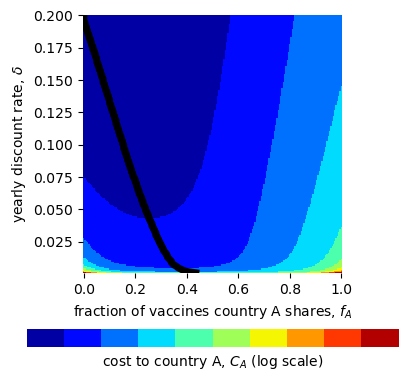

In [17]:
plot_heatmap('f_A','delta','logUA',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='yearly discount rate, $\delta$',
             legendTitle='cost to country A, $C_A$ (log scale)', colorbar_shrink=.75)
plt.plot(f_A_min_deltas, deltas, color='black', linewidth=5)

# plt.savefig('figures/roughs/f_A_delta.png', bbox_inches='tight', dpi=1200)

In [18]:
### for figure f_As

time1 = time.time()

f_As = np.linspace(0,1,201)
rhos = np.linspace(0,.5,201)

f_A_rho_logUAs = np.transpose(np.log([get_C_A(f_A, rho=rhos) for f_A in f_As]))

f_A_min_rhos = f_As[np.argmin(f_A_rho_logUAs,axis=1)]

time2 = time.time()
print(time2 - time1)

304.14157605171204


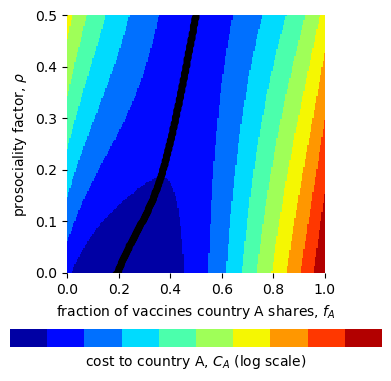

In [19]:
plot_heatmap('f_A','rho','logUA',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel=r'prosociality factor, $\rho$',
             legendTitle='cost to country A, $C_A$ (log scale)', colorbar_shrink=.75)
plt.plot(f_A_min_rhos, rhos, color='black', linewidth=5)

# plt.savefig('figures/roughs/f_A_rho.png', bbox_inches='tight', dpi=1200)

In [1677]:
### for figure deltas
### or supplementary figure rho_delta_low_sigma if sigma set to .9 with lines
### C_As = [get_C_A(f_A, delta=deltas/365, rho=rhos, sigma=.9) for f_A in f_As]
### rho_delta_f_A_min_low_sigmas = f_As[np.argmin(C_As, axis=0)]

time1 = time.time()

deltas = np.linspace(.001,.2,200)
rhos = np.linspace(0,.5,201)
f_As = np.sort(np.append(np.linspace(.001,.451,10), np.linspace(.049,.499,10)))

C_As = [get_C_A(f_A, delta=deltas/365, rho=rhos) for f_A in f_As]
rho_delta_f_A_mins = f_As[np.argmin(C_As, axis=0)]

time2 = time.time()
print(time2 - time1)

108.45934891700745


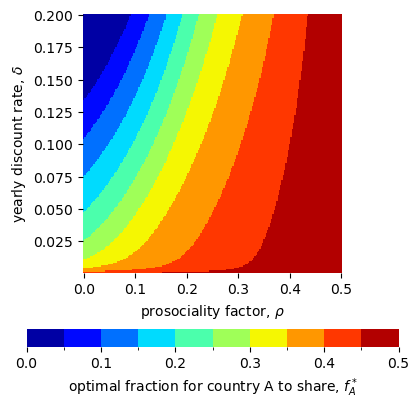

In [10]:
# if sigma set to .9 replace first line with
# plot_heatmap('rho','delta','f_A_min_low_sigma',fracValues=True,
plot_heatmap('rho','delta','f_A_min',fracValues=True,
             xlabel=r'prosociality factor, $\rho$', ylabel='yearly discount rate, $\delta$',
             legendTitle='optimal fraction for country A to share, $f_A^*$', colorbar_shrink=.75)

# plt.savefig('figures/roughs/rho_delta.png', bbox_inches='tight', dpi=1200)
### or if sigma set to .9
# plt.savefig('figures/roughs/rho_delta_low_sigma.png', bbox_inches='tight', dpi=1200)

In [1631]:
### for figure deltas

time1 = time.time()

deltas = np.linspace(.001,.2,200)
etas = np.linspace(0,.2,201)
f_As = np.sort(np.append(np.linspace(.001,.451,10), np.linspace(.049,.499,10)))

C_As = [np.transpose([get_C_A(f_A, delta=deltas/365, eta=eta) for eta in etas]) for f_A in f_As]
eta_delta_f_A_mins = f_As[np.argmin(C_As, axis=0)]

time2 = time.time()
print(time2 - time1)

6262.363415956497

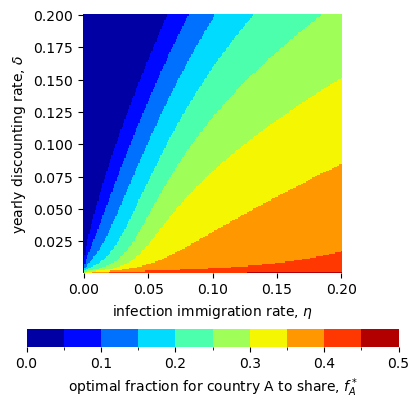

In [20]:
plot_heatmap('eta','delta','f_A_min',fracValues=True,
             xlabel='infection immigration rate, $\eta$', ylabel='yearly discounting rate, $\delta$',
             legendTitle='optimal fraction for country A to share, $f_A^*$', colorbar_shrink=.75)

# plt.savefig('figures/roughs/eta_delta.png', bbox_inches='tight', dpi=1200)

In [1632]:
### for figure deltas

time1 = time.time()

deltas = np.linspace(.001,.2,200)
log10mus = np.linspace(-1,3,201)
f_As = np.sort(np.append(np.linspace(.001,.451,10), np.linspace(.049,.499,10)))

C_As = [np.transpose([get_C_A(f_A, delta=deltas/365, mu=10**log10mu) for log10mu in log10mus]) for f_A in f_As]
log10mu_delta_f_A_mins = f_As[np.argmin(C_As, axis=0)]

time2 = time.time()
print(time2 - time1)

6080.704704046249

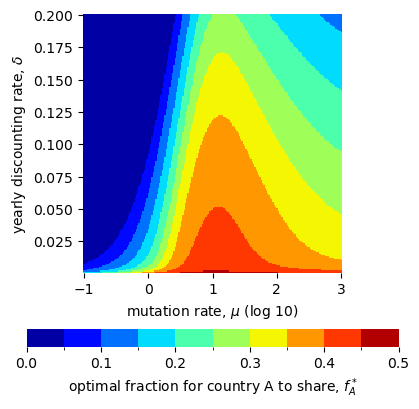

In [21]:
plot_heatmap('log10mu','delta','f_A_min',fracValues=True,
             xlabel='mutation rate, $\mu$ (log 10)', ylabel='yearly discounting rate, $\delta$',
             legendTitle='optimal fraction for country A to share, $f_A^*$', colorbar_shrink=.75)

# plt.savefig('figures/roughs/log10mu_delta.png', bbox_inches='tight', dpi=1200)

In [1633]:
### for figure deltas
### or supplementary figure R0_delta_low_sigma if sigma set to .9 with line
### C_As = [np.transpose([get_C_A(f_A, delta=deltas/365, beta=R0*gamma_def, sigma=.9) for R0 in R0s]) for f_A in f_As]
### R0_delta_f_A_min_low_sigmas = f_As[np.argmin(C_As, axis=0)]

time1 = time.time()

deltas = np.linspace(.001,.2,200)
R0s = np.linspace(1, 3, 201)
f_As = np.sort(np.append(np.linspace(.001,.451,10), np.linspace(.049,.499,10)))

C_As = [np.transpose([get_C_A(f_A, delta=deltas/365, beta=R0*gamma_def) for R0 in R0s]) for f_A in f_As]
R0_delta_f_A_mins = f_As[np.argmin(C_As, axis=0)]

time2 = time.time()
print(time2 - time1)

6405.723634004593

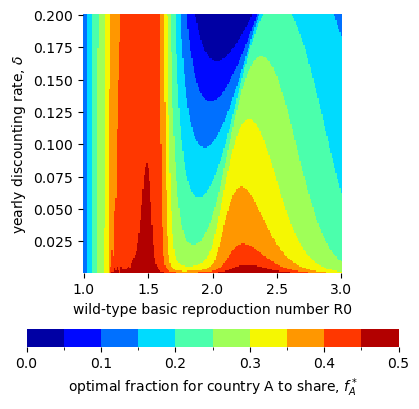

In [22]:
# if sigma set to .9 replace first line with
# plot_heatmap('R0','delta','f_A_min_low_sigma',fracValues=True,
plot_heatmap('R0','delta','f_A_min',fracValues=True,
             xlabel='wild-type basic reproduction number R0', ylabel='yearly discounting rate, $\delta$',
             legendTitle='optimal fraction for country A to share, $f_A^*$', colorbar_shrink=.75)

# plt.savefig('figures/roughs/R0_delta.png', bbox_inches='tight', dpi=1200)
### or if sigma set to .9
# plt.savefig('figures/roughs/R0_delta_low_sigma.png', bbox_inches='tight', dpi=1200)

In [1656]:
### for supplementary figure nu_delta

time1 = time.time()

deltas = np.linspace(.001,.2,200)
nus = np.linspace(.5,2.5,201)
f_As = np.sort(np.append(np.linspace(.001,.451,10), np.linspace(.049,.499,10)))

C_As = [np.transpose([get_C_A(f_A, delta=deltas/365, nu=nu/365) for nu in nus]) for f_A in f_As]
nu_delta_f_A_mins = f_As[np.argmin(C_As, axis=0)]

time2 = time.time()
print(time2 - time1)

6476.610540151596


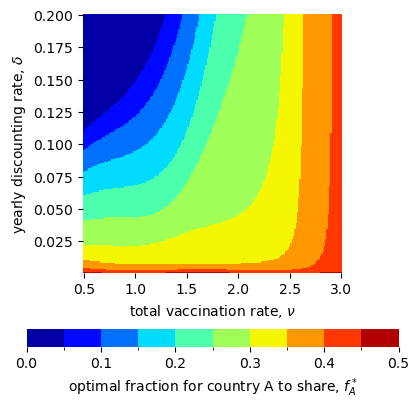

In [23]:
# if sigma set to .9 replace first line with
# plot_heatmap('nu','delta','f_A_min_low_sigma',fracValues=True,
plot_heatmap('nu','delta','f_A_min',fracValues=True,
             xlabel=r'total vaccination rate, $\nu$', ylabel='yearly discounting rate, $\delta$',
             legendTitle='optimal fraction for country A to share, $f_A^*$', colorbar_shrink=.75)

# plt.savefig('figures/nu_delta.pdf', bbox_inches='tight', dpi=1200)

In [1687]:
### save simulation results (except Cs.txt) if desired

# with open('sim_results/eta_delta_f_A_mins.txt', 'w') as f:
#     f.write(str(list(eta_delta_f_A_mins)))
# with open('sim_results/log10mu_delta_f_A_mins.txt', 'w') as f:
#     f.write(str(list(log10mu_delta_f_A_mins)))
# with open('sim_results/R0_delta_f_A_mins.txt', 'w') as f:
#     f.write(str(list(R0_delta_f_A_mins)))


### for supplementary figures

# with open('sim_results/rho_delta_f_A_min_low_sigmas.txt', 'w') as f:
#     f.write(str(list(rho_delta_f_A_min_low_sigmas)))
# with open('sim_results/R0_delta_f_A_min_low_sigmas.txt', 'w') as f:
#     f.write(str(list(R0_delta_f_A_min_low_sigmas)))

# with open('sim_results/nu_delta_f_A_mins.txt', 'w') as f:
#     f.write(str(list(nu_delta_f_A_mins)))

In [37]:
# run this block (takes ~18 hours) or run Cs.py on cluster and upload it using next block

time1 = time.time()

fs = np.linspace(0,1,201)

C_As = np.empty((len(fs),len(fs)))
C_Bs = np.empty((len(fs),len(fs)))

for i, f_B in enumerate(fs):
    if i % 10 == 0:
        print(str(i) + ' out of ' + str(200))
    
    for j, f_A in enumerate(fs):
        C_A, C_B = get_Cs(f_A, f_B=f_B, mu=10)
        C_As[i,j] = C_A
        C_Bs[i,j] = C_B

time2 = time.time()
print(time2 - time1)

0 out of 200
10 out of 200
20 out of 200
30 out of 200
40 out of 200
50 out of 200
60 out of 200
70 out of 200
80 out of 200
90 out of 200
100 out of 200
110 out of 200
120 out of 200
130 out of 200
140 out of 200
150 out of 200
160 out of 200
170 out of 200
180 out of 200
190 out of 200
200 out of 200
61643.03496813774


In [25]:
# if HPC is available to use Cs.py to create Cs.txt

with open('sim_results/Cs.txt', 'r') as f:
    Cs = ast.literal_eval(f.read().replace('), np.float64(',',').replace('np.float64(','').replace('))',')'))
C_As = np.array([[a for a,b in x] for x in Cs])
C_Bs = np.array([[b for a,b in x] for x in Cs])
fs = np.linspace(0,1,len(Cs))
f_As = f_Bs = fs

In [38]:
cost_slope_low = 5
cost_slope_medium = 20
cost_slope_high = 50

log_C_A_nos = np.log(C_As)
log_C_A_lows = np.log(C_As)
log_C_A_mediums = np.log(C_As)
log_C_A_highs = np.log(C_As)

log_C_B_nos = np.log(C_Bs)
log_C_B_lows = np.log(C_Bs + cost_slope_low * np.repeat(np.transpose([fs]), len(fs), axis=1))
log_C_B_mediums = np.log(C_Bs + cost_slope_medium * np.repeat(np.transpose([fs]), len(fs), axis=1))
log_C_B_highs = np.log(C_Bs + cost_slope_high * np.repeat(np.transpose([fs]), len(fs), axis=1))


f_A_min_ixs = [np.argmin(log_C_A_nos[i,:]) for i in range(0,len(fs))]
f_A_min_nos = fs[f_A_min_ixs]
f_B_min_ixs = [np.argmin(log_C_B_nos[:,i]) for i in range(0,len(fs))]
f_B_min_nos = fs[f_B_min_ixs]

f_A_star = f_A_min_nos[-1]
f_A_star_ix = f_A_min_ixs[-1]


f_A_min_ixs = [np.argmin(log_C_A_lows[i,:]) for i in range(0,len(fs))]
f_A_min_lows = fs[f_A_min_ixs]
f_B_min_ixs = [np.argmin(log_C_B_lows[:,i]) for i in range(0,len(fs))]
f_B_min_lows = fs[f_B_min_ixs]

f_A_min_ixs = [np.argmin(log_C_A_mediums[i,:]) for i in range(0,len(fs))]
f_A_min_mediums = fs[f_A_min_ixs]
f_B_min_ixs = [np.argmin(log_C_B_mediums[:,i]) for i in range(0,len(fs))]
f_B_min_mediums = fs[f_B_min_ixs]

f_A_min_ixs = [np.argmin(log_C_A_highs[i,:]) for i in range(0,len(fs))]
f_A_min_highs = fs[f_A_min_ixs]
f_B_min_ixs = [np.argmin(log_C_B_highs[:,i]) for i in range(0,len(fs))]
f_B_min_highs = fs[f_B_min_ixs]

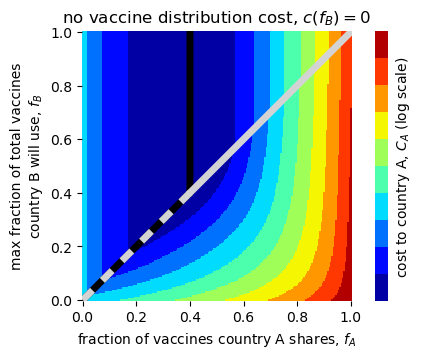

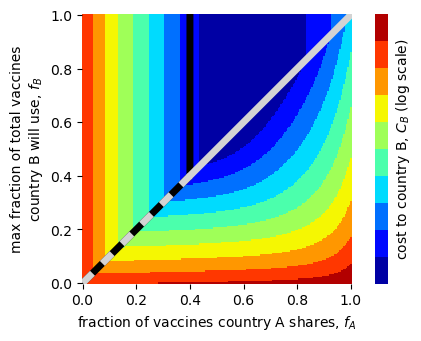

In [39]:
### for supplementary figure f_Bs_no_cost

# no cost

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_A_no',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country A, $C_A$ (log scale)',
             vertical_colorbar=True)
plt.plot(f_A_min_nos,fs,color='black',linewidth=5)
ixs = (f_A_min_nos==fs) & (f_B_min_nos==fs)
plt.plot(fs[ixs],f_B_min_nos[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_nos[~ixs],color='lightgray',linewidth=5)
plt.title('no vaccine distribution cost, $c(f_B)=0$')

# plt.savefig('figures/roughs/no_cost_UA.png', bbox_inches='tight', dpi=1200)

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_B_no',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country B, $C_B$ (log scale)',
             vertical_colorbar=True)
plt.plot(f_A_min_nos,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_nos[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_nos[~ixs],color='lightgray',linewidth=5)

# plt.savefig('figures/roughs/no_cost_UB.png', bbox_inches='tight', dpi=1200)

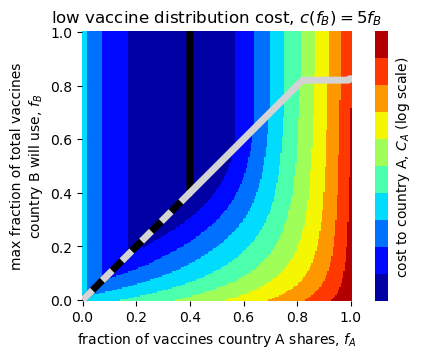

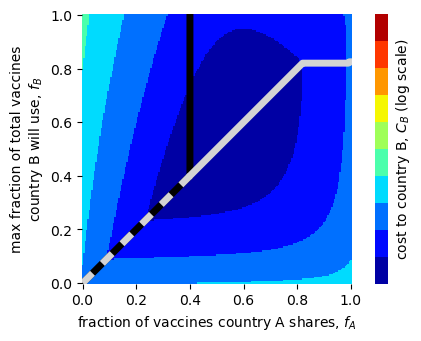

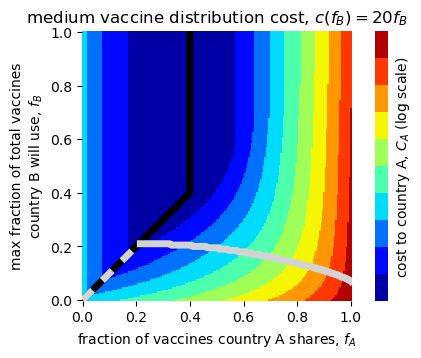

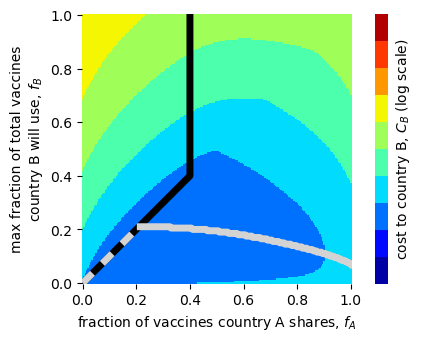

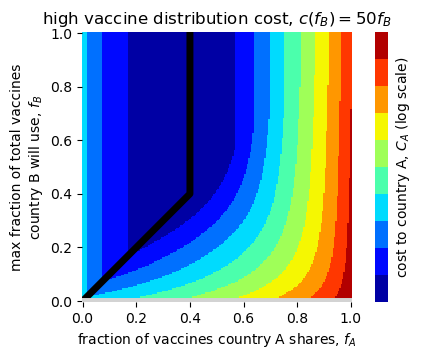

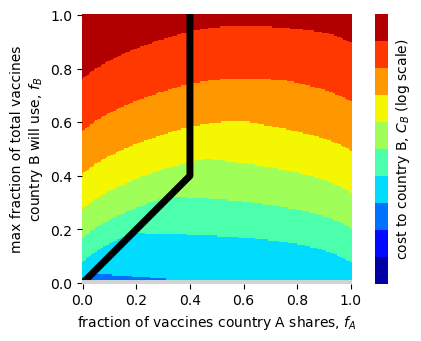

In [40]:
# for figure f_Bs

log_C_B_min = min(np.min(log_C_B_lows), np.min(log_C_B_mediums), np.min(log_C_B_highs))
log_C_B_max = max(np.max(log_C_B_lows), np.max(log_C_B_mediums), np.max(log_C_B_highs))


# low cost

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_A_low',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country A, $C_A$ (log scale)',
             vertical_colorbar=True)
ixs = (f_A_min_lows==fs) & (f_B_min_lows==fs)
plt.plot(f_A_min_lows,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_lows[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_lows[~ixs],color='lightgray',linewidth=5)
plt.title('low vaccine distribution cost, $c(f_B)=$' + str(cost_slope_low) + '$f_B$')

# plt.savefig('figures/roughs/low_cost_UA.png', bbox_inches='tight', dpi=1200)

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_B_low',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country B, $C_B$ (log scale)',
             vertical_colorbar=True, legend_min=log_C_B_min, legend_max=log_C_B_max)
plt.plot(f_A_min_lows,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_lows[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_lows[~ixs],color='lightgray',linewidth=5)

# plt.savefig('figures/roughs/low_cost_UB.png', bbox_inches='tight', dpi=1200)



# medium cost

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_A_medium',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country A, $C_A$ (log scale)',
             vertical_colorbar=True)
ixs = (f_A_min_mediums==fs) & (f_B_min_mediums==fs)
plt.plot(f_A_min_mediums,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_mediums[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_mediums[~ixs],color='lightgray',linewidth=5)
plt.title('medium vaccine distribution cost, $c(f_B)=$' + str(cost_slope_medium) + '$f_B$')

# plt.savefig('figures/roughs/medium_cost_UA.png', bbox_inches='tight', dpi=1200)

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_B_medium',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country B, $C_B$ (log scale)',
             vertical_colorbar=True, legend_min=log_C_B_min, legend_max=log_C_B_max)
plt.plot(f_A_min_mediums,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_mediums[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_mediums[~ixs],color='lightgray',linewidth=5)

# plt.savefig('figures/roughs/medium_cost_UB.png', bbox_inches='tight', dpi=1200)



# high cost

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_A_high',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country A, $C_A$ (log scale)',
             vertical_colorbar=True)
ixs = (f_A_min_highs==fs) & (f_B_min_highs==fs)
plt.plot(f_A_min_highs,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_highs[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_highs[~ixs],color='lightgray',linewidth=5)
plt.title('high vaccine distribution cost, $c(f_B)=$' + str(cost_slope_high) + '$f_B$')

# plt.savefig('figures/roughs/high_cost_UA.png', bbox_inches='tight', dpi=1200)

plt.figure(figsize=(6,3.5))
plot_heatmap('f_A', 'f_B', 'log_C_B_high',
             xlabel='fraction of vaccines country A shares, $f_A$', ylabel='max fraction of total vaccines\ncountry B will use, $f_B$', legendTitle='cost to country B, $C_B$ (log scale)',
             vertical_colorbar=True, legend_min=log_C_B_min, legend_max=log_C_B_max)
plt.plot(f_A_min_highs,fs,color='black',linewidth=5)
plt.plot(fs[ixs],f_B_min_highs[ixs],color='lightgray',linewidth=5,linestyle=(0,(2,2)))
plt.plot(fs[~ixs],f_B_min_highs[~ixs],color='lightgray',linewidth=5)

# plt.savefig('figures/roughs/high_cost_UB.png', bbox_inches='tight', dpi=1200)

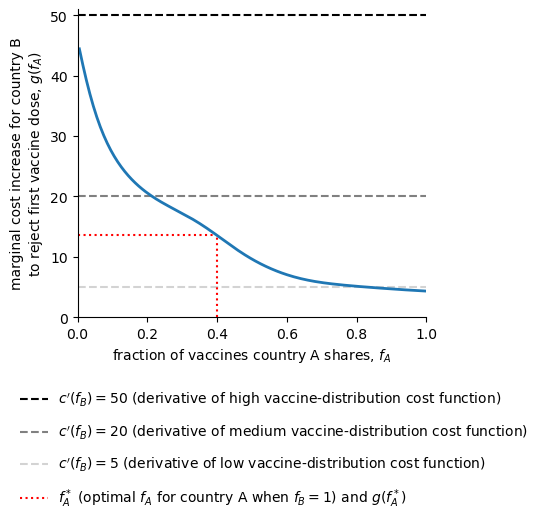

In [41]:
# for supplementary figure g_f_A

gs = [(C_Bs[i-1,i]-C_Bs[i,i])/fs[1] for i in range(1,len(fs))]

plt.figure(figsize=(4.5,4))
plt.axhline(y=cost_slope_high, color='black', linewidth=1.5, linestyle='dashed', label='$c\'(f_B)=50$ (derivative of high vaccine-distribution cost function)') 
plt.axhline(y=cost_slope_medium, color='gray', linewidth=1.5, linestyle='dashed', label='$c\'(f_B)=20$ (derivative of medium vaccine-distribution cost function)')
plt.axhline(y=cost_slope_low, color='lightgray', linewidth=1.5, linestyle='dashed', label='$c\'(f_B)=5$ (derivative of low vaccine-distribution cost function)')

plt.plot([f_A_star]*2, [0, gs[f_A_star_ix-1]], linewidth=1.5, color='red', linestyle='dotted', label='$f_A^*$ (optimal $f_A$ for country A when $f_B=1$) and $g(f_A^*)$')
plt.plot([0, f_A_star], [gs[f_A_star_ix-1]]*2, linewidth=1.5, color='red', linestyle='dotted')

plt.plot(fs[1:], gs, linewidth=2)

plt.xlim(0,1)
plt.ylim(0,cost_slope_high+1)
plt.margins(x=0,y=0)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('fraction of vaccines country A shares, $f_A$')
plt.ylabel('marginal cost increase for country B\nto reject first vaccine dose, $g(f_A)$')
plt.legend(loc='center left', bbox_to_anchor=(-.2, -.43), frameon=False, labelspacing=1, handlelength=2, handletextpad=0.7)

# plt.savefig('figures/g_f_A.pdf', bbox_inches='tight')

In [30]:
# returns time step that the variant emerges given its time series
def emergence_tstep(I_v, ts_per_tstep=1):
    return next(ix for ix,y in enumerate(I_v) if y > 0) // ts_per_tstep

tstep = 7
ts_per_tstep = tstep
tsteps = int(4*365/tstep) + 1

In [31]:
### this and next 5 cells create figure example
### or set R0 to 1.5 to create supplementary figure example_low_R0
### by adding option beta=1.5*gamma_def to each instant of get_dCs (and minor graphical changes)
_, all_ts, _, _, \
pw, pA, pB, A_weights, B_weights, \
_, _, Iw_wA, _, \
_, _, Iw_wB, _, \
_, _, IA_wAs, IA_vAs, _, \
_, _, _, _, _, \
_, _, IB_wAs, IB_vAs, _, \
_, _, _, _, _ = get_dCs(f_A=0, mu=10,
                        track_vars=True, r_tolerance=1e-5, tstep=tstep, tsteps=tsteps, ts_per_tstep=ts_per_tstep)
### or if R0 set to 1.5, replace last line with
#                         beta=1.5*gamma_def, track_vars=True, r_tolerance=1e-5, tstep=tstep, tsteps=tsteps, ts_per_tstep=ts_per_tstep)

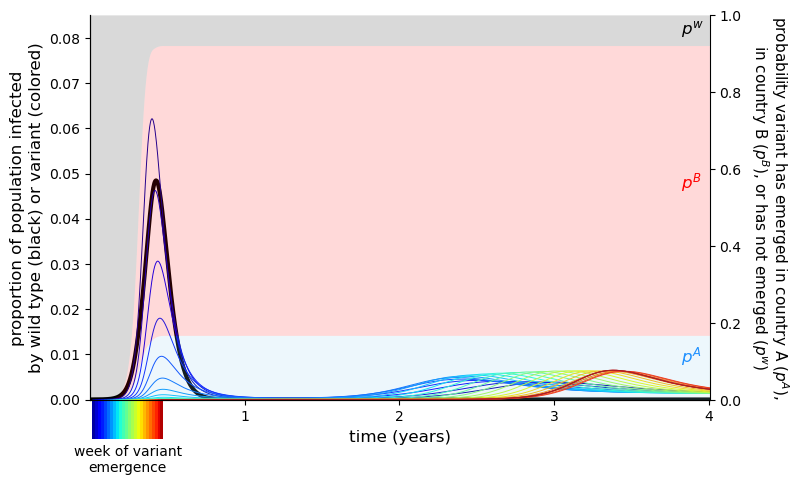

In [32]:
fig, ax = plt.subplots(figsize=(8, 5))

twin = ax.twinx()

twin.stackplot(all_ts/365, pA, pB, pw, colors=['skyblue','red','black'], alpha=.15)
twin.spines[['right', 'top']].set_visible(False)
twin.margins(x=0,y=0)


twin.text(3.82,.95, '$p^w$', fontsize=12, fontweight = 'bold')
twin.text(3.82,.55, '$p^B$', fontsize=12, fontweight = 'bold', color='red')
twin.text(3.82,.1, '$p^A$', fontsize=12, fontweight = 'bold', color='dodgerblue')
### if R0 set to 1.5, replace last 3 lines with 
# twin.text(3.82,.8, '$p^w$', fontsize=12, fontweight = 'bold')
# twin.text(3.82,.3, '$p^B$', fontsize=12, fontweight = 'bold', color='red')
# twin.text(4.13,.04, '$p^A$', fontsize=12, fontweight = 'bold', color='dodgerblue')

twin.set_ylabel('probability variant has emerged in country A ($p^A$),\nin country B ($p^B$), or has not emerged ($p^w$)',
                size=11, rotation=270, labelpad=35, linespacing=.9)

kA = len(A_weights)
kB = len(B_weights)
emergence_tsteps_A = [emergence_tstep(IA_vAs[:,i], ts_per_tstep) for i in range(kA)]
emergence_tsteps_B = [emergence_tstep(IB_vAs[:,i], ts_per_tstep) for i in range(kB)]
emergence_tsteps_all = list(set(emergence_tsteps_A + emergence_tsteps_B))

bounds = range(emergence_tsteps_all[0], emergence_tsteps_all[-1] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

I_w = pw * Iw_wA
for t in emergence_tsteps_all:
    if t in emergence_tsteps_A and t in emergence_tsteps_B:
        I_w += A_weights[emergence_tsteps_A.index(t)] * IA_wAs[:,emergence_tsteps_A.index(t)] + \
               B_weights[emergence_tsteps_B.index(t)] * IB_wAs[:,emergence_tsteps_B.index(t)]
    elif t in emergence_tsteps_A:
        I_w += A_weights[emergence_tsteps_A.index(t)] * IA_wAs[:,emergence_tsteps_A.index(t)]
    else:
        I_w += B_weights[emergence_tsteps_B.index(t)] * IB_wAs[:,emergence_tsteps_B.index(t)]

ax.plot(all_ts/365, I_w, color='black', linewidth=3)

        
for t in emergence_tsteps_all:
    if t in emergence_tsteps_A and t in emergence_tsteps_B:
        I_vA = (IA_vAs[:,emergence_tsteps_A.index(t)] + IB_vAs[:,emergence_tsteps_B.index(t)]) / 2
    elif t in emergence_tsteps_A:
        I_vA = IA_vAs[:,emergence_tsteps_A.index(t)]
    else:
        I_vA = IB_vAs[:,emergence_tsteps_B.index(t)]

    ax.plot(all_ts[I_vA>0]/365, I_vA[I_vA>0],
             linewidth=.7, color = cmap(norm(t)))

ax.spines[['top']].set_visible(False)
ax.set_xlabel('time (years)', size=12)
ax.set_ylabel('proportion of population infected\nby wild type (black) or variant (colored)', size=12, linespacing=1.3)
ax.set_ylim(-.00019,.085)
### if R0 set to 1.5, replace last line with
# ax.set_ylim(-.00012,.05)
ax.set_xticks(range(1,5))
ax.margins(x=0,y=0)

cbax = ax.inset_axes([emergence_tsteps_all[0]/tsteps*.8, -.101, (emergence_tsteps_all[-1]-emergence_tsteps_all[0])/tsteps, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, cax=cbax,
                    orientation='horizontal', location='bottom', ticks=[])
cbar.outline.set_visible(False)
cbar.minorticks_off()
cbar.set_label(label='week of variant\nemergence')

# plt.savefig('figures/roughs/example_low_fA.svg', bbox_inches='tight')
### or if R0 set to 1.5
# plt.savefig('figures/roughs/example_low_R0_low_fA.svg', bbox_inches='tight')

In [33]:
_, all_ts, _, _, \
pw, pA, pB, A_weights, B_weights, \
_, _, Iw_wA, _, \
_, _, Iw_wB, _, \
_, _, IA_wAs, IA_vAs, _, \
_, _, _, _, _, \
_, _, IB_wAs, IB_vAs, _, \
_, _, _, _, _ = get_dCs(f_A=.4, mu=10,
                        track_vars=True, r_tolerance=1e-5, tstep=tstep, tsteps=tsteps, ts_per_tstep=ts_per_tstep)
### or if R0 set to 1.5, replace last line with
#                         beta=1.5*gamma_def, track_vars=True, r_tolerance=1e-5, tstep=tstep, tsteps=tsteps, ts_per_tstep=ts_per_tstep)

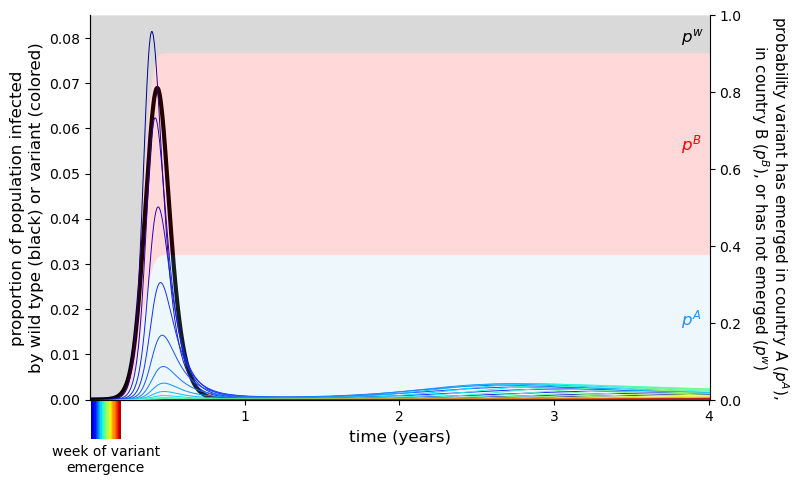

In [42]:
fig, ax = plt.subplots(figsize=(8, 5))

twin = ax.twinx()

twin.stackplot(all_ts/365, pA, pB, pw, colors=['skyblue','red','black'], alpha=.15)
twin.spines[['right', 'top']].set_visible(False)
twin.margins(x=0,y=0)

twin.text(3.82,.93, '$p^w$', fontsize=12, fontweight = 'bold')
twin.text(3.82,.65, '$p^B$', fontsize=12, fontweight = 'bold', color='red')
twin.text(3.82,.195, '$p^A$', fontsize=12, fontweight = 'bold', color='dodgerblue')
### if R0 set to 1.5, replace last 3 lines with 
# twin.text(3.82,.5, '$p^w$', fontsize=12, fontweight = 'bold')
# twin.text(3.85,.075, '$p^B$', fontsize=12, fontweight = 'bold', color='red')
# twin.text(4.13,.04, '$p^A$', fontsize=12, fontweight = 'bold', color='dodgerblue')
twin.set_ylabel('probability variant has emerged in country A ($p^A$),\nin country B ($p^B$), or has not emerged ($p^w$)',
                size=11, rotation=270, labelpad=35, linespacing=.9)

kA = len(A_weights)
kB = len(B_weights)
emergence_tsteps_A = [emergence_tstep(IA_vAs[:,i], ts_per_tstep) for i in range(kA)]
emergence_tsteps_B = [emergence_tstep(IB_vAs[:,i], ts_per_tstep) for i in range(kB)]
emergence_tsteps_all = list(set(emergence_tsteps_A + emergence_tsteps_B))

bounds = range(emergence_tsteps_all[0], emergence_tsteps_all[-1] + 1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

I_w = pw * Iw_wA
for t in emergence_tsteps_all:
    if t in emergence_tsteps_A and t in emergence_tsteps_B:
        I_w += A_weights[emergence_tsteps_A.index(t)] * IA_wAs[:,emergence_tsteps_A.index(t)] + \
               B_weights[emergence_tsteps_B.index(t)] * IB_wAs[:,emergence_tsteps_B.index(t)]
    elif t in emergence_tsteps_A:
        I_w += A_weights[emergence_tsteps_A.index(t)] * IA_wAs[:,emergence_tsteps_A.index(t)]
    else:
        I_w += B_weights[emergence_tsteps_B.index(t)] * IB_wAs[:,emergence_tsteps_B.index(t)]

ax.plot(all_ts/365, I_w, color='black', linewidth=3)

        
for t in emergence_tsteps_all:
    if t in emergence_tsteps_A and t in emergence_tsteps_B:
        I_vA = (IA_vAs[:,emergence_tsteps_A.index(t)] + IB_vAs[:,emergence_tsteps_B.index(t)]) / 2
    elif t in emergence_tsteps_A:
        I_vA = IA_vAs[:,emergence_tsteps_A.index(t)]
    else:
        I_vA = IB_vAs[:,emergence_tsteps_B.index(t)]

    ax.plot(all_ts[I_vA>0]/365, I_vA[I_vA>0],
             linewidth=.7, color = cmap(norm(t)))

ax.spines[['top']].set_visible(False)
ax.set_xlabel('time (years)', size=12)
ax.set_ylabel('proportion of population infected\nby wild type (black) or variant (colored)', size=12, linespacing=1.3)
ax.set_ylim(-.00019,.085)
### if R0 set to 1.5, replace last line with
# ax.set_ylim(-.00012,.05)
ax.set_xticks(range(1,5))
ax.margins(x=0,y=0)

cbax = ax.inset_axes([emergence_tsteps_all[0]/tsteps*.8, -.101, (emergence_tsteps_all[-1]-emergence_tsteps_all[0])/tsteps, 0.1])
cbar = fig.colorbar(mpl.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax, cax=cbax,
                    orientation='horizontal', location='bottom', ticks=[])
cbar.outline.set_visible(False)
cbar.minorticks_off()
cbar.set_label(label='week of variant\nemergence')

# plt.savefig('figures/roughs/example_high_fA.svg', bbox_inches='tight')
### or if R0 set to 1.5
# plt.savefig('figures/roughs/example_low_R0_high_fA.svg', bbox_inches='tight')

In [35]:
tsteps = int(10*365/tstep) + 1

tstep_ts, _, dC_A1 = \
    get_dCs(f_A=0, mu=10, track_vars=True, r_tolerance=1e-5, tsteps=tsteps, ts_per_tstep=ts_per_tstep)[:3]
### or if R0 set to 1.5, replace last line with
#     get_dCs(f_A=0, mu=10, beta=1.5*gamma_def, track_vars=True, r_tolerance=1e-5, tsteps=tsteps, ts_per_tstep=ts_per_tstep)[:3]

tstep_ts, _, dC_A2 = \
    get_dCs(f_A=.4, mu=10, track_vars=True, r_tolerance=1e-5, tsteps=tsteps, ts_per_tstep=ts_per_tstep)[:3]
### or if R0 set to 1.5, replace last line with
#     get_dCs(f_A=.4, mu=10, beta=1.5*gamma_def, track_vars=True, r_tolerance=1e-5, tsteps=tsteps, ts_per_tstep=ts_per_tstep)[:3]

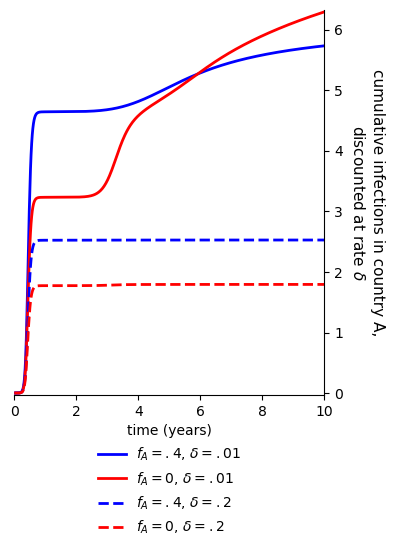

In [36]:
fig = plt.figure(figsize=(4,5))

plt.plot(tstep_ts/365, np.cumsum(np.exp(-.01/(365/tstep)*tstep_ts) * dC_A2),
         linewidth=2, color='blue', label='$f_A=.4$, $\delta=.01$')
plt.plot(tstep_ts/365, np.cumsum(np.exp(-.01/(365/tstep)*tstep_ts) * dC_A1),
         linewidth=2, color='red', label='$f_A=0$, $\delta=.01$')

plt.plot(tstep_ts/365, np.cumsum(np.exp(-.2/(365/tstep)*tstep_ts) * dC_A2),
         linewidth=2, color='blue', linestyle='dashed', label='$f_A=.4$, $\delta=.2$')
plt.plot(tstep_ts/365, np.cumsum(np.exp(-.2/(365/tstep)*tstep_ts) * dC_A1),
         linewidth=2, color='red', linestyle='dashed', label='$f_A=0$, $\delta=.2$')

ax = plt.gca()
ax.yaxis.tick_right()
ax.margins(x=0,y=.005)
ax.spines[['left','top']].set_visible(False)
ax.set_xlabel('time (years)')
ax.set_ylabel('cumulative infections in country A,\ndiscounted at rate $\delta$',
              rotation=270, labelpad=30, linespacing=1.3, size=11)
ax.yaxis.set_label_position('right')
plt.legend(loc='lower center', bbox_to_anchor=(.5, -.4), frameon=False, labelspacing=.5, handlelength=2, handletextpad=0.7)

# plt.savefig('figures/roughs/example_C_As.svg', bbox_inches='tight')
### or if R0 set to 1.5
# plt.savefig('figures/roughs/example_low_R0_C_As.svg', bbox_inches='tight')